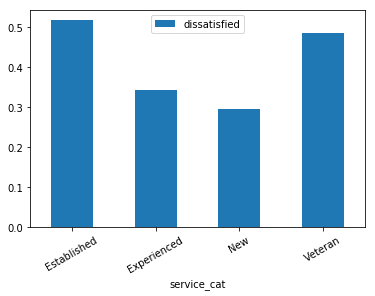

In [12]:
import pandas as pd
import numpy as np
dete_survey=pd.read_csv('dete_survey.csv',na_values='Not Stated')
tafe_survey=pd.read_csv('tafe_survey.csv', na_values='Not Stated')
dete_survey_updated = dete_survey.drop(dete_survey.columns[28:49], axis=1)
tafe_survey_updated = tafe_survey.drop(tafe_survey.columns[17:66], axis=1)

dete_survey_updated.columns = dete_survey_updated.columns.str.replace(' ','_').str.lower().str.strip()

mapping = {'Record ID': 'id', 'CESSATION YEAR': 'cease_date', 'Reason for ceasing employment': 'separationtype', 'Gender. What is your Gender?': 'gender', 'CurrentAge. Current Age': 'age',
       'Employment Type. Employment Type': 'employment_status',
       'Classification. Classification': 'position',
       'LengthofServiceOverall. Overall Length of Service at Institute (in years)': 'institute_service',
       'LengthofServiceCurrent. Length of Service at current workplace (in years)': 'role_service'}
tafe_survey_updated = tafe_survey_updated.rename(mapping, axis = 1)
dete_survey_updated['separationtype']=dete_survey_updated['separationtype'].str.split('-').str[0]
tafe_survey_updated['separationtype']=tafe_survey_updated['separationtype'].str.split('-').str[0]
dete_resignations=dete_survey_updated[dete_survey_updated['separationtype']=='Resignation'].copy()
tafe_resignations=tafe_survey_updated[tafe_survey_updated['separationtype']=='Resignation'].copy()
dete_resignations['cease_date']=dete_resignations['cease_date'].str.split('/').str[-1]
dete_resignations['cease_date']=dete_resignations['cease_date'].astype('float')
dete_resignations['institute_service']=dete_resignations['cease_date']-dete_resignations['dete_start_date']
def update_vals(x):
    if x == '-':
        return False
    elif pd.isnull(x):
        return np.nan
    else:
        return True
tafe_resignations['dissatisfied'] = tafe_resignations[['Contributing Factors. Dissatisfaction', 'Contributing Factors. Job Dissatisfaction']].applymap(update_vals).any(1, skipna=False)
tafe_resignations_up = tafe_resignations.copy()

dete_resignations['dissatisfied'] = dete_resignations[['job_dissatisfaction',
       'dissatisfaction_with_the_department', 'physical_work_environment',
       'lack_of_recognition', 'lack_of_job_security', 'work_location',
       'employment_conditions', 'work_life_balance',
       'workload']].any(1, skipna=False)
dete_resignations_up = dete_resignations.copy()
dete_resignations_up['dissatisfied'].value_counts(dropna=False)

dete_resignations_up['institute'] = 'DETE'
tafe_resignations_up['institute'] = 'TAFE'
combined = pd.concat([dete_resignations_up, tafe_resignations_up], ignore_index=True, sort=False)

# Verify the number of non null values in each column
combined.notnull().sum().sort_values()
# Drop columns with less than 500 non null values
combined_updated = combined.dropna(thresh = 500, axis =1).copy()
# Extract the years of service and convert the type to float
combined_updated['institute_service_up'] = combined_updated['institute_service'].astype('str').str.extract(r'(\d+)')
combined_updated['institute_service_up'] = combined_updated['institute_service_up'].astype('float')
def transform_service(val):
    if val >= 11:
        return "Veteran"
    elif 7 <= val < 11:
        return "Established"
    elif 3 <= val < 7:
        return "Experienced"
    elif pd.isnull(val):
        return np.nan
    else:
        return "New"
combined_updated['service_cat'] = combined_updated['institute_service_up'].apply(transform_service)

# Replace missing values with the most frequent value, False
combined_updated['dissatisfied'] = combined_updated['dissatisfied'].fillna(False)


# Calculate the percentage of employees who resigned due to dissatisfaction in each category
dis_pct = combined_updated.pivot_table(index='service_cat',values='dissatisfied')


%matplotlib inline
dis_pct.plot(kind='bar', rot=30)


